In [20]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import tempo, util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

In [21]:
year = 2025
filename = './output/year_sim/one_year_' + str(year) + '.pickle'
with open(filename, 'rb') as f:
    res = pickle.load(f)
res.add_los_coloumns()

In [22]:
stat = 'AAU'
print('loaded!')
e = res.elv(stat + '_elev')
print(type(e.values))

loaded!
<class 'numpy.ndarray'>


In [23]:
import mani_rain
from mani.StateEvaluator import SEEnum
condition = res.above_elev(stat+'_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])
elevations = res.df.loc[condition][stat+'_elev']

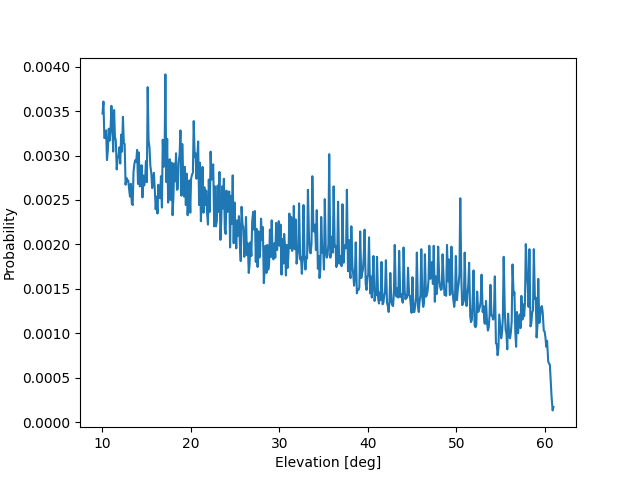

In [24]:
with open('./output/elevations/'+stat+'_elevations.pickle', 'wb') as f:
    pickle.dump(elevations, f, protocol=pickle.HIGHEST_PROTOCOL)
nn = mani_rain.new_norcia
nn.gen_el_dist(file='./output/elevations/'+stat+'_elevations.pickle')

plt.figure()
plt.plot(*nn.el_distribution)
plt.xlabel("Elevation [deg]")
plt.ylabel("Probability")
plt.show()

link = mani_rain.link_budget_itu(nn, 100e6)
# dist = 384400e3
# rain_rate = 4 #mmhr⁻¹
# rain_rates = np.full(len(elevations), rain_rate)
# snr_list = []
# for idx, el in enumerate(elevations):
#     snr_list.append(link.snr_at_t(dist, el, rain_rates[idx]))
# plt.figure()
# plt.plot(elevations, snr_list)
# plt.grid()
# plt.xlabel("Elevation [Deg]")
# plt.ylabel("SNR [dB]")
# plt.show()

In [40]:
from tqdm import tqdm

link = mani_rain.link_budget_itu(nn, 100e6)

aau = mani_rain.station_t (
    lat = 57.014,
    lon = 9.986,
    height = 0.02,
    frequency = 32,
    gt = 41.55,
    diamaeter = 5.6)
link = mani_rain.link_budget_itu(aau, 50e6, link_margin=6)

generator = np.random.default_rng()
does_rain_p = generator.binomial(1, 0.028, res.get_length())

hmr = generator.uniform(0.01, 2.8, sum(does_rain_p))
idx = 0

rainrates = np.empty_like(does_rain_p)
for i, _ in enumerate(tqdm(rainrates)):
    if does_rain_p[i] > 0:
        link.rain_model.p = hmr[idx]
        rainrates[i] = link.rain_model.rain_rate
        idx += 1
    else:
        rainrates[i] = 0
print(rainrates.shape)


condition = res.above_elev(stat+'_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_AAU])
gw_los = res.has([SEEnum.LOS_GW])

st_snrs = np.empty(res.get_length())
st_rates = np.empty(res.get_length())
gw_snrs = np.empty(res.get_length())
gw_rates = np.empty(res.get_length())

for i in tqdm(range(res.get_length())):
    dist = res.df.iloc[i][stat+'_dist'] * 1e3
    elev = res.df.iloc[i][stat+'_elev']
    gw_dist = res.df.iloc[i]['gw_dist']
    if condition[i]:
        st_snrs[i] = link.snr_at_t(dist, elev, rainrates[i])
        st_rates[i] = link.dvb_s2_cap(st_snrs[i])
    else:
        st_snrs[i] = np.nan
        st_rates[i] = 0

    if gw_los[i]:
        gw_rates[i] = 16 * 1e6
    else:
        gw_rates[i] = 0

100%|██████████| 525601/525601 [00:33<00:00, 15562.13it/s]


(525601,)


100%|██████████| 525601/525601 [00:26<00:00, 19556.85it/s]


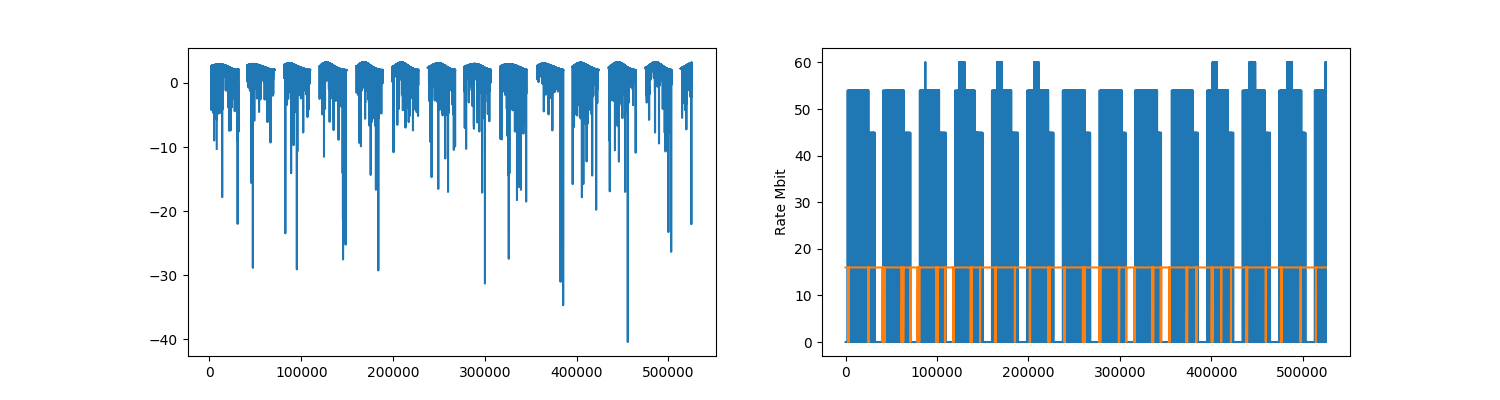

10.592271967968788


In [41]:
%matplotlib widget
fig = plt.figure(figsize=(15, 4))
ax0, ax1 = fig.subplots(1,2)
ax0.plot(st_snrs)
ax1.step(range(len(gw_rates)), st_rates / 1e6, label = 'gs')
ax1.step(range(len(gw_rates)), gw_rates / 1e6, label = 'gw')
ax1.set_ylabel('Rate Mbit')
plt.show()
print(np.mean(st_rates) / 1e6)

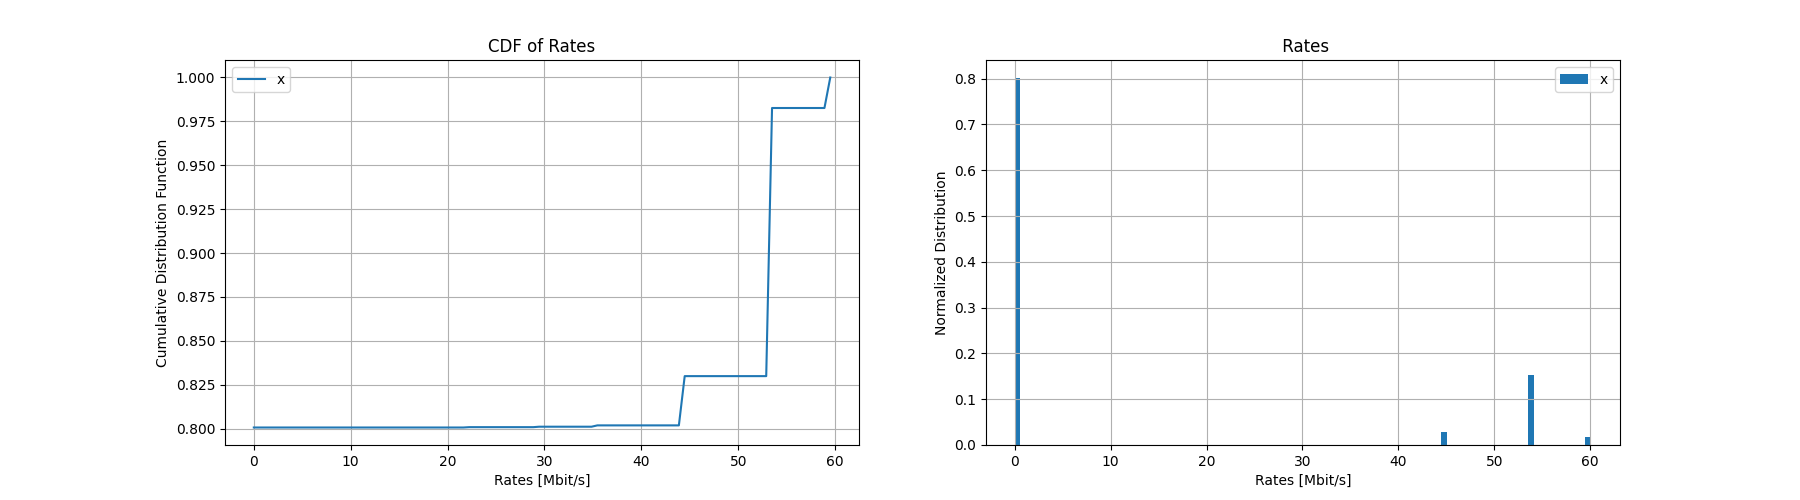

In [42]:
def plot_cdf(ax, bins,vals, name):
    ax.plot(bins[:-1], np.cumsum(vals), label = name)
    ax.grid()
    ax.set_xlabel('Rates [Mbit/s]')
    ax.set_ylabel('Cumulative Distribution Function')
    ax.legend()
    ax.set_title('CDF of Rates')

def plot_hist(ax, arr, name):
    ax.hist(arr, bins = 100, weights=np.ones(len(arr)) / len(arr), label = name)
    ax.grid()
    ax.set_xlabel('Rates [Mbit/s]')
    ax.set_ylabel('Normalized Distribution')
    ax.set_title(' Rates')
    ax.legend()

fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
arr = st_rates / 1e6

name = 'x'
vals, bins = np.histogram(arr, bins=100, weights=np.ones(len(arr)) / len(arr))
plot_cdf(ax0, bins, vals, name)

plot_hist(ax1, arr, name)

plt.show()

In [43]:
idx = 0
condition = res.above_elev('NN11_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])
for i in tqdm(range(len(condition))):
    if (condition[i]) & (st_rates[i] == 0):
        idx += 1
print(idx)
print(len(condition))
print(idx / len(condition))

100%|██████████| 525601/525601 [00:00<00:00, 898996.28it/s]

107375
525601
0.2042899461759015


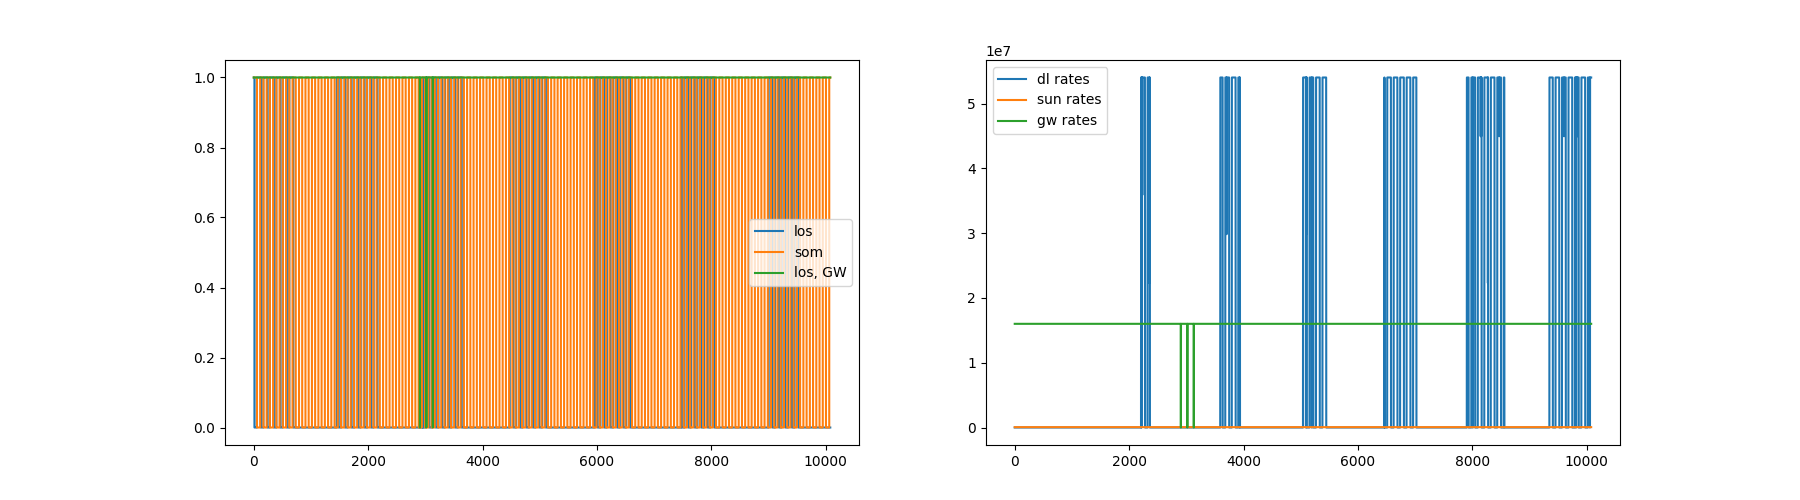

In [48]:
n = 0
m = 24*60*7
rs = [4.5 * 1e9 / (24*60*60)] * m
rd = st_rates[n:n+m]
los = res['los_nn'][n:n+m].values
som = res.has([SEEnum.SUN_ON_MOON])[n:n+m].values
gwlos = res.has([SEEnum.LOS_GW])[n:n+m].values
gwr = gw_rates[n:n+m]
fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
ax0.step(range(m), los, label = 'los')
ax0.step(range(m), som, label = 'som')
ax0.step(range(m), gwlos, label = 'los, GW')
ax0.legend()

ax1.plot(range(m), rd, label='dl rates')
ax1.plot(range(m), rs, label='sun rates')
ax1.plot(range(m), gwr, label= 'gw rates')
ax1.legend()
plt.show()


with open('./tmp/los.pickle', 'wb') as f:
    pickle.dump(los,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/som.pickle', 'wb') as f:
    pickle.dump(som,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/rs.pickle', 'wb') as f:
    pickle.dump(rs,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/rd.pickle', 'wb') as f:
    pickle.dump(rd,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/gwr.pickle', 'wb') as f:
    pickle.dump(gwr,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/gwlos.pickle', 'wb') as f:
    pickle.dump(gwlos,f,protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
lat_deg =  57.0927889
lat =  np.radians(lat_deg)
lon = np.radians(9.8491639)

b = 6357 
a = 6378
z = (a - b) * (lat_deg / 90)
R = b + z

x = R * np.cos(lat) * np.cos(lon)

y = R * np.cos(lat) * np.sin(lon)

z = R * np.sin(lat)
print([x,y,z])

[3409.861022959618, 591.9989195310555, 5348.213067680093]


# NN

  0%|          | 1590/525601 [00:00<00:33, 15757.00it/s]

100%|██████████| 525601/525601 [00:34<00:00, 15426.47it/s]


(525601,)


100%|██████████| 525601/525601 [00:18<00:00, 28408.77it/s]


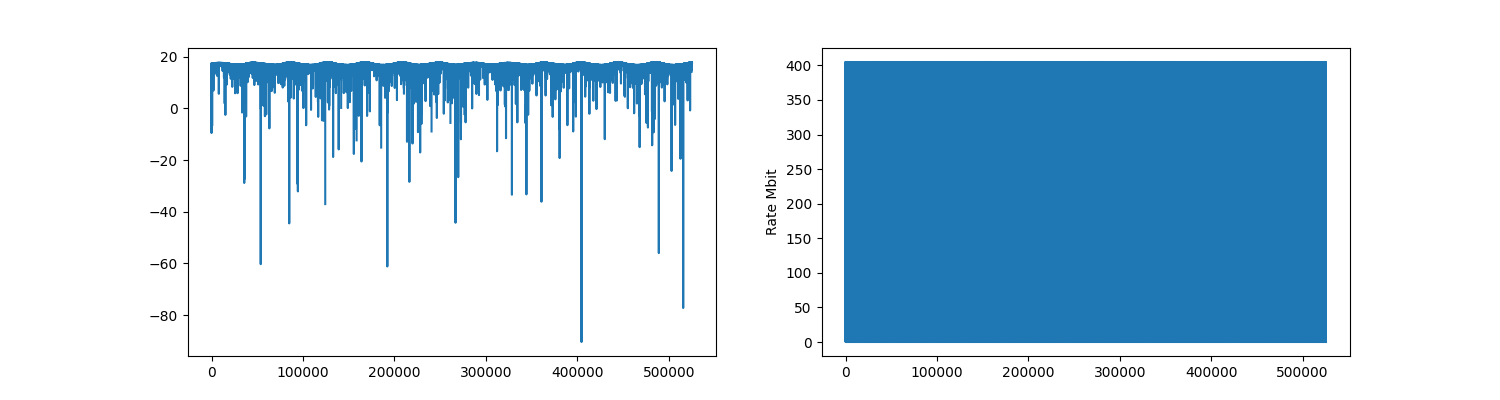

104.89539100243861


100%|██████████| 525601/525601 [00:00<00:00, 924182.98it/s]

74
525601
0.00014079120854031861


In [31]:
from tqdm import tqdm
stat = 'NN11'
nn = mani_rain.new_norcia
link = mani_rain.link_budget_itu(nn, 100e6)

# aau = mani_rain.station_t (
#     lat = 57.014,
#     lon = 9.986,
#     height = 0.02,
#     frequency = 32,
#     gt = 41.55,
#     diamaeter = 5.6)
# link = mani_rain.link_budget_itu(aau, 50e6, link_margin=6)

generator = np.random.default_rng()
does_rain_p = generator.binomial(1, 0.028, res.get_length())

hmr = generator.uniform(0.01, 2.8, sum(does_rain_p))
idx = 0

rainrates = np.empty_like(does_rain_p)
for i, _ in enumerate(tqdm(rainrates)):
    if does_rain_p[i] > 0:
        link.rain_model.p = hmr[idx]
        rainrates[i] = link.rain_model.rain_rate
        idx += 1
    else:
        rainrates[i] = 0
print(rainrates.shape)


condition = res.above_elev(stat+'_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])

st_snrs = np.empty(res.get_length())
st_rates = np.empty(res.get_length())
gw_snrs = np.empty(res.get_length())
gw_rates = np.empty(res.get_length())

for i in tqdm(range(res.get_length())):
    dist = res.df.iloc[i][stat+'_dist'] * 1e3
    elev = res.df.iloc[i][stat+'_elev']
    if condition[i]:
        st_snrs[i] = link.snr_at_t(dist, elev, rainrates[i])
        st_rates[i] = link.dvb_s2_cap(st_snrs[i])
    else:
        st_snrs[i] = np.nan
        st_rates[i] = 0

%matplotlib widget
fig = plt.figure(figsize=(15, 4))
ax0, ax1 = fig.subplots(1,2)
ax0.plot(st_snrs)
ax1.plot(st_rates / 1e6)
ax1.set_ylabel('Rate Mbit')
plt.show()
print(np.mean(st_rates) / 1e6)

idx = 0
condition = res.above_elev('NN11_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])
for i in tqdm(range(len(condition))):
    if (condition[i]) & (st_rates[i] == 0):
        idx += 1
print(idx)
print(len(condition))
print(idx / len(condition))

# AAU

  0%|          | 0/525601 [00:00<?, ?it/s]

100%|██████████| 525601/525601 [00:33<00:00, 15727.82it/s]


(525601,)


100%|██████████| 525601/525601 [00:18<00:00, 29162.77it/s]


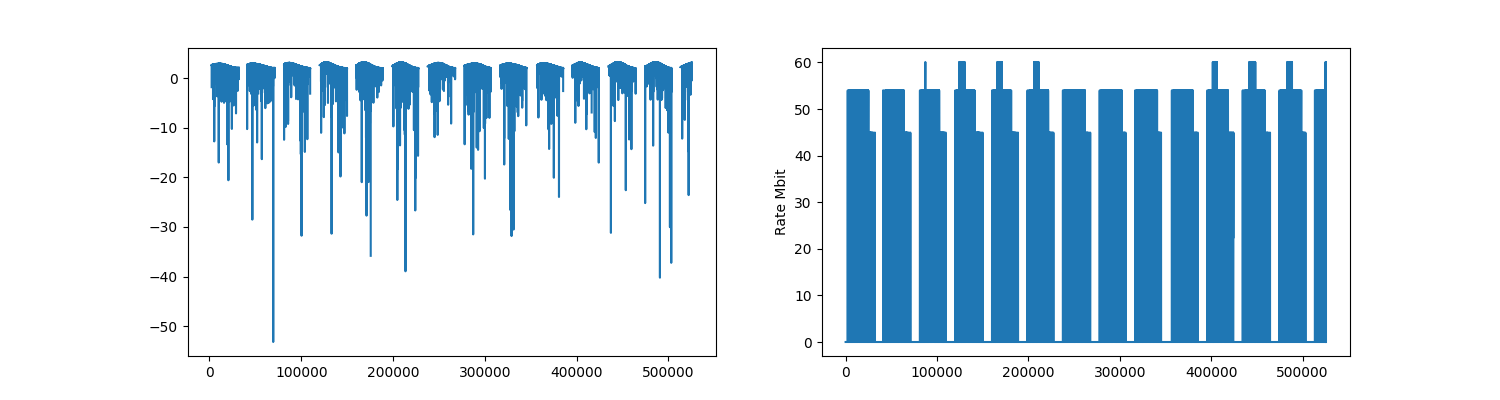

10.586532370994863


100%|██████████| 525601/525601 [00:00<00:00, 900669.65it/s]

292
525601
0.0005555544985645004


In [32]:
from tqdm import tqdm
stat = 'AAU'

aau = mani_rain.station_t (
    lat = 57.014,
    lon = 9.986,
    height = 0.02,
    frequency = 32,
    gt = 41.55,
    diamaeter = 5.6)
link = mani_rain.link_budget_itu(aau, 50e6, link_margin=6)

generator = np.random.default_rng()
does_rain_p = generator.binomial(1, 0.028, res.get_length())

hmr = generator.uniform(0.01, 2.8, sum(does_rain_p))
idx = 0

rainrates = np.empty_like(does_rain_p)
for i, _ in enumerate(tqdm(rainrates)):
    if does_rain_p[i] > 0:
        link.rain_model.p = hmr[idx]
        rainrates[i] = link.rain_model.rain_rate
        idx += 1
    else:
        rainrates[i] = 0
print(rainrates.shape)


condition = res.above_elev(stat+'_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_AAU])

st_snrs = np.empty(res.get_length())
st_rates = np.empty(res.get_length())
gw_snrs = np.empty(res.get_length())
gw_rates = np.empty(res.get_length())

for i in tqdm(range(res.get_length())):
    dist = res.df.iloc[i][stat+'_dist'] * 1e3
    elev = res.df.iloc[i][stat+'_elev']
    if condition[i]:
        st_snrs[i] = link.snr_at_t(dist, elev, rainrates[i])
        st_rates[i] = link.dvb_s2_cap(st_snrs[i])
    else:
        st_snrs[i] = np.nan
        st_rates[i] = 0

%matplotlib widget
fig = plt.figure(figsize=(15, 4))
ax0, ax1 = fig.subplots(1,2)
ax0.plot(st_snrs)
ax1.plot(st_rates / 1e6)
ax1.set_ylabel('Rate Mbit')
plt.show()
print(np.mean(st_rates) / 1e6)

idx = 0
condition = res.above_elev('AAU_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_AAU])
for i in tqdm(range(len(condition))):
    if (condition[i]) & (st_rates[i] == 0):
        idx += 1
print(idx)
print(len(condition))
print(idx / len(condition))

In [34]:

print(res.df['gw_dist'].min())
print(res.df['gw_dist'].max())
print(res.df['gw_dist'].mean())

2862
76746
47764.79961796115
